In [1]:
# Study: EDA - Envisioned Speech Recognition
# Author: Willian Oliveira
# Start: 30/09/2022
# Motivation: Discover how to work with EEG exams.
# Study Status: On going

# First Atempt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import mne
import seaborn as sns
import random

mne.set_log_level('WARNING') # Setting outputs to something less verbose.

In [3]:
# This is too verbose, but we will keep it as a record of my thinking process to understand this dataset.
def explore_edf_data(path):
    """ Extract raw data from EDF files, print some info about this measurement."""
    import mne
    raw = mne.io.read_raw_edf(path)
    print(f'{path} metadata:') 
    display(raw.info) # Explore metadata included in the file
    channels = raw.ch_names # Display all channels available in this EEG.
    print(f'Channel Names:\n')
    print(channels,'\n')
    print(5*'-', '\n')
    print('Transforming transposed edf data to np array...\n')
    data = raw.get_data().T # Transform this transposed raw data in array information
    print(f'Data size: {data.size}')
    print(f'Data shape: {data.shape} -> {data.shape[0]} measurements of {data.shape[1]} channels' )
    print('Each nested array is composed of 39 float numbers, indicating one measure of each channel at the same time.\n')
    print('Channels Values at the first measurement period:')
    print(data[0], '\n')
    print('Channels Values at the last measurement period:')
    print(data[-1], '\n')
    print(5*'-', '\n')
    print('Converting np array to dataframe for further analysis...\n')
    df_data = pd.DataFrame(data, columns=channels)
    display(df_data.describe().style)
    print('\n')
    print('We see that the sensor channels for this task are from AF3 to AF4 [2:16].') 
    plt.rcParams["figure.figsize"] = (20,8)
    print(f'Seconds of analysis: {round((df_data.TIME_STAMP_s.max() - df_data.TIME_STAMP_s.min())*(10**6))}')
    for c in channels[2:16]:
        plt.plot(df_data[c], label = str(c))
        plt.title(f'Sensor channels response for subject thinking on this EEG')


Char/aashay_A.edf metadata:


<Info | 7 non-empty values
 bads: []
 ch_names: COUNTER, INTERPOLATED, AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, ...
 chs: 39 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2017-02-25 20:29:24 UTC
 nchan: 39
 projs: []
 sfreq: 128.0 Hz
>

Channel Names:

['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY', 'MARKER', 'SYNC', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL'] 

----- 

Transforming transposed edf data to np array...

Data size: 59904
Data shape: (1536, 39) -> 1536 measurements of 39 channels
Each nested array is composed of 39 float numbers, indicating one measure of each channel at the same time.

Channels Values at the first measurement period:
[5.40000000e-05 0.00000000e+00 4.22410256e-03 4.22820513e-03
 4.22615385e-03 4.22666667e-03 4.22205128e-03 4.22461538e-03
 4.21333333e-03 4.22256410e-03 4.21435897e-03 4.23282051e-03
 4.22871795e-03 4.24615385e-03 4.23179487e-03 4.22205128e-03
 0.00000000e+00 2.04700000e-03 2.04200000e-03 0.00000000e+00
 0.00000000e+00 1.20200000e-03 5.69000000

,COUNTER,INTERPOLATED,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,RAW_CQ,GYROX,GYROY,MARKER,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_F7,CQ_F3,CQ_FC5,CQ_T7,CQ_P7,CQ_O1,CQ_O2,CQ_P8,CQ_T8,CQ_FC6,CQ_F4,CQ_F8,CQ_AF4,CQ_CMS,CQ_DRL
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000
mean,0.000064,0.000000,0.004231,0.004233,0.004232,0.004232,0.004231,0.004228,0.004231,0.004231,0.004232,0.004233,0.004232,0.004227,0.004231,0.004232,0.000396,0.002046,0.002042,0.000000,0.000000,0.001208,0.000500,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
std,0.000037,0.000000,0.000175,0.000174,0.000173,0.000160,0.000009,0.000027,0.000189,0.000193,0.000930,0.000003,0.000169,0.000016,0.000169,0.000157,0.000415,0.000003,0.000003,0.000000,0.000000,0.000004,0.000288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.003453,0.003453,0.003450,0.003849,0.004199,0.004130,0.003389,0.003358,0.000615,0.004222,0.003450,0.004163,0.003500,0.003483,0.000000,0.002036,0.002022,0.000000,0.000000,0.001202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000032,0.000000,0.004207,0.004209,0.004215,0.004213,0.004224,0.004218,0.004211,0.004215,0.004203,0.004231,0.004214,0.004222,0.004208,0.004215,0.000000,0.002044,0.002040,0.000000,0.000000,0.001205,0.000253,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
50%,0.000064,0.000000,0.004225,0.004226,0.004229,0.004238,0.004232,0.004232,0.004227,0.004230,0.004227,0.004233,0.004227,0.004226,0.004224,0.004229,0.000000,0.002046,0.002042,0.000000,0.000000,0.001208,0.000504,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
75%,0.000096,0.000000,0.004249,0.004257,0.004252,0.004253,0.004238,0.004242,0.004247,0.004251,0.004261,0.004234,0.004247,0.004236,0.004246,0.004248,0.000840,0.002047,0.002043,0.000000,0.000000,0.001211,0.000747,0.000004,0.000004,0.000004,0.000004,0.000000,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004
max,0.000128,0.000000,0.004917,0.004881,0.004820,0.005029,0.004254,0.004351,0.004925,0.004817,0.007707,0.004243,0.004832,0.004254,0.004802,0.004944,0.001007,0.002061,0.002049,0.000000,0.000000,0.001214,0.001000,0.000004,0.000004,0.000004,0.000004,0.000000,0.000001,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004,0.000004,0.000000,0.000004,0.000004




We see that the sensor channels for this task are from AF3 to AF4 [2:16].
Seconds of analysis: 12


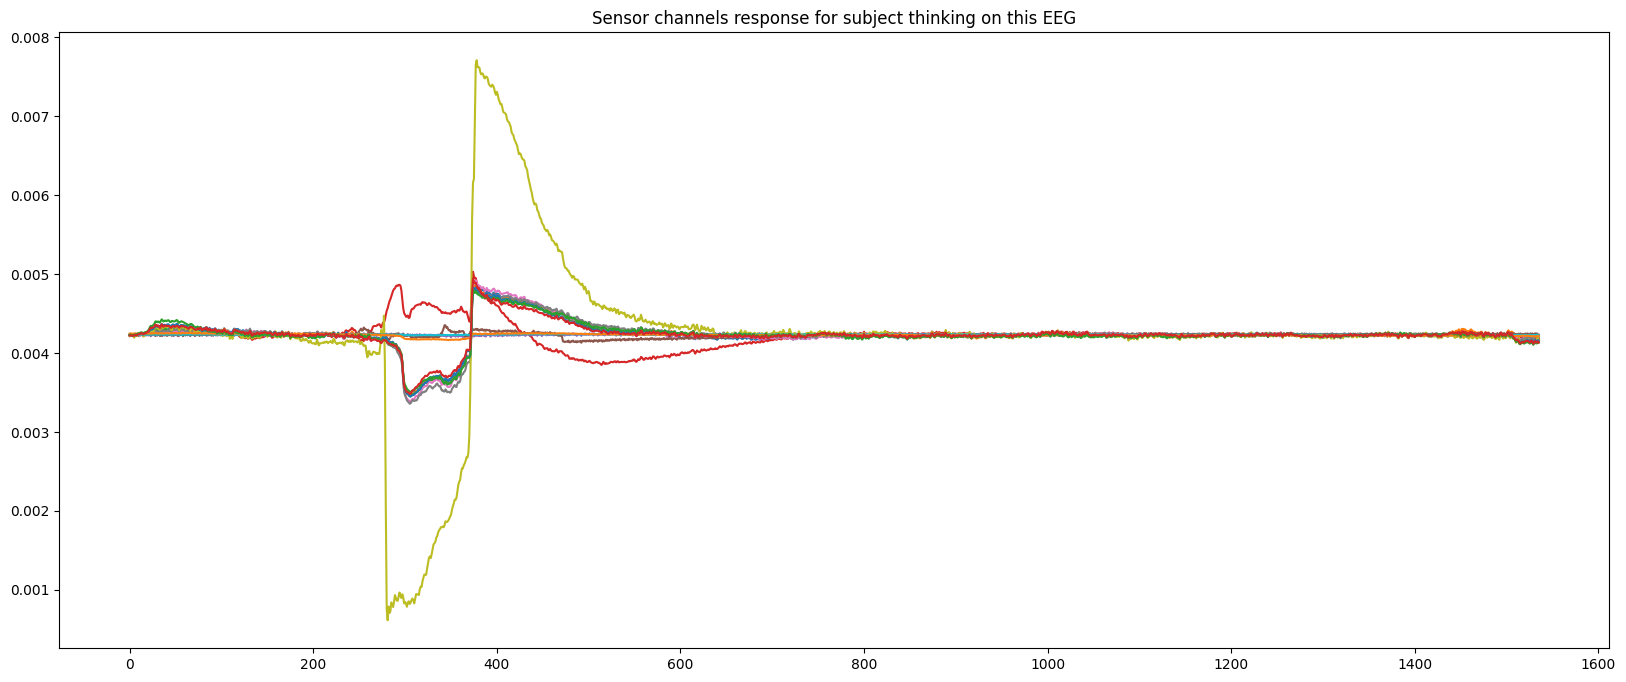

In [4]:
explore_edf_data('Char/aashay_A.edf')

In [5]:
# Creating a np.array with all EEG data and its label for Char Envisioned Recognition task.
folder = 'Char/'
CHANNELS = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] 
ctr = 0
X = np.zeros((230,14,1280))
Y = np.zeros((230,))
ctr = 0

for file in os.listdir(folder):
    data = mne.io.read_raw_edf(os.path.join(folder,file))
    raw_data = data[2:16][0]*1000
    raw_data = raw_data[:,0:1280]
    
    _,cls = file.split('_')
    if cls[0]=='A':
        Y[ctr] = 0
    elif cls[0]=='C':
        Y[ctr] = 1 
    elif cls[0]=='F':
        Y[ctr] = 2
    elif cls[0]=='H':
        Y[ctr] = 3
    elif cls[0]=='J':
        Y[ctr] = 4
    elif cls[0]=='M':
        Y[ctr] = 5
    elif cls[0]=='P':
        Y[ctr] = 6
    elif cls[0]=='S':
        Y[ctr] = 7
    elif cls[0]=='T':
        Y[ctr] = 8
    elif cls[0]=='Y':
        Y[ctr] = 9
    X[ctr,:,:] = raw_data
    ctr = ctr+1

In [6]:
# Lets build a dictionary to mantain our char labels in memory. 
LABEL_STR = {0.0: 'A', 1.0: 'C', 2.0: 'F', 3.0: 'H', 4.0: 'J',
             5.0: 'M', 6.0: 'P', 7.0: 'S', 8.0: 'T', 9.0: 'Y'}

In [7]:
# Lets explore EEG readings in our dataset.
def explore_dataset(Doc, Measurements = X, Labels = Y, Channels = CHANNELS, labels_str = LABEL_STR):
    df = pd.DataFrame(X[Doc].T, columns=Channels)
    print(f'Exploring exam number {Doc}')
    print(f'Label: {labels_str[Labels[Doc]]}')
    print('Channels first mesurements:')
    display(df.head().style)
    plt.rcParams["figure.figsize"] = (20,8)
    for c in CHANNELS:
        plt.plot(df[c], label = str(c))
        plt.title(f'Sensor channels response for subject thinking on char {labels_str[Labels[Doc]]} for ~12 seconds.')

Exploring exam number 222
Label: F
Channels first mesurements:


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4.252308,4.222564,4.265641,4.233846,4.227692,4.218974,4.216923,4.274359,4.226667,4.232821,4.291282,4.206667,4.273846,4.258974
1,4.241538,4.197949,4.226667,4.210769,4.231795,4.236410,4.233333,4.251282,4.203590,4.233333,4.251795,4.244103,4.229744,4.229231
2,4.246154,4.226154,4.248718,4.234359,4.227179,4.235897,4.224615,4.281538,4.215385,4.233846,4.275385,4.290256,4.260000,4.243590
3,4.271795,4.246667,4.281026,4.258462,4.233333,4.240513,4.276923,4.302051,4.275385,4.233846,4.303077,4.353333,4.283590,4.271282
4,4.237949,4.209231,4.242051,4.224103,4.225641,4.234872,4.228718,4.249231,4.223077,4.232821,4.256410,4.356923,4.233333,4.228718


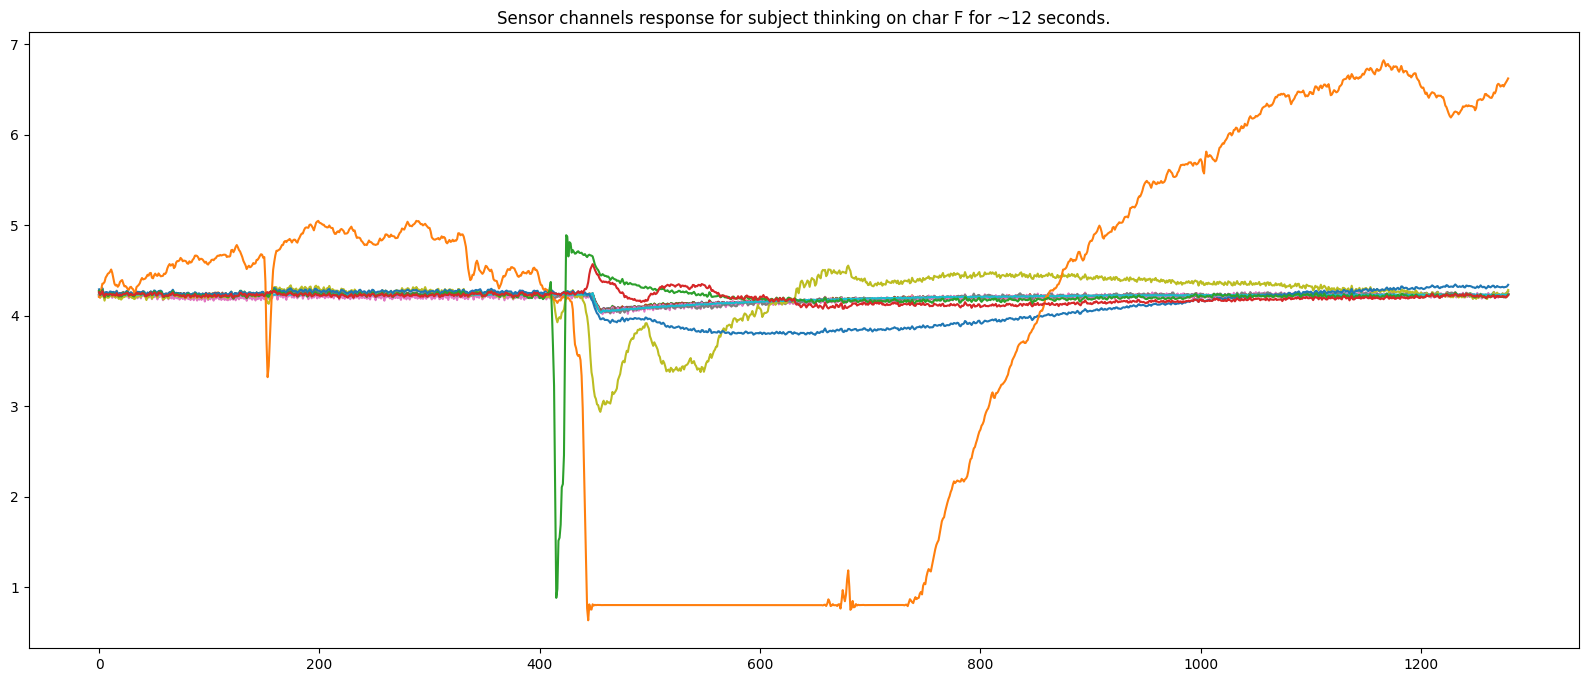

In [8]:
explore_dataset(Doc= random.randint(0, 230), Measurements = X, Labels = Y, Channels = CHANNELS)

In [9]:
print(X.shape)
print(Y.shape)

(230, 14, 1280)
(230,)


In [10]:
# Save as npz file to use it on the other notebooks.
np.savez('char_dataset', x=X, y=Y)

In [11]:
# Load npz file to see if its in the right configuration.
dataset = np.load('char_dataset.npz')
Measurements = dataset['x']
Labels = dataset['y']
print(Measurements.shape)
print(Labels.shape)

(230, 14, 1280)
(230,)


Exploring exam number 4
Label: J
Channels first mesurements:


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4.312308,4.274872,4.291282,4.263590,4.223590,4.222051,4.256410,4.274872,4.371795,4.236923,4.341026,4.230256,4.387179,4.333846
1,4.320513,4.277949,4.298462,4.269231,4.234359,4.229744,4.262051,4.271795,4.381538,4.235897,4.348718,4.232308,4.389231,4.339487
2,4.320000,4.282051,4.306154,4.275897,4.238462,4.230769,4.265128,4.274872,4.376410,4.232308,4.344615,4.233846,4.376923,4.338462
3,4.322051,4.297949,4.309744,4.279487,4.222051,4.216923,4.270256,4.281026,4.351795,4.231282,4.341538,4.233333,4.378974,4.340000
4,4.324103,4.293846,4.305128,4.277949,4.238974,4.231795,4.272821,4.278974,4.373333,4.234872,4.341538,4.234359,4.380000,4.334359


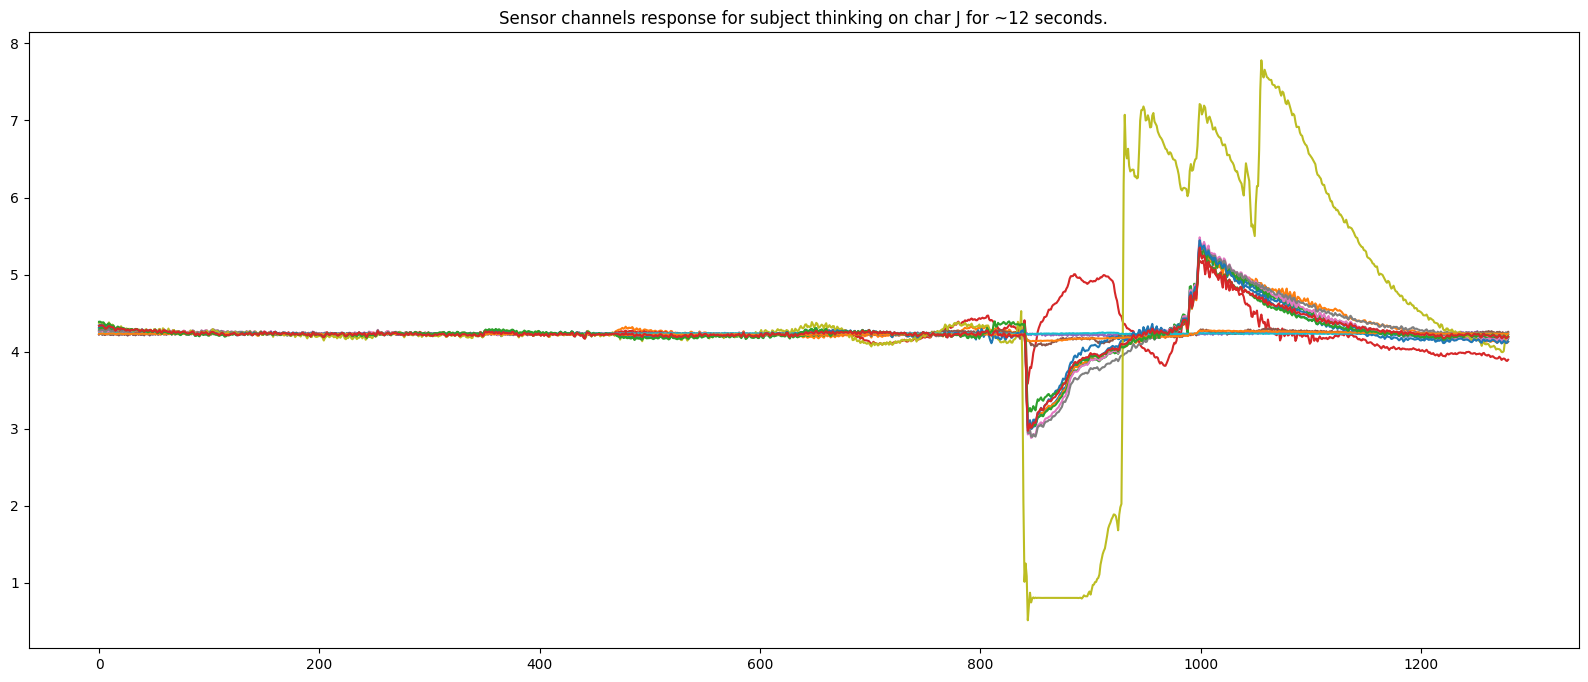

In [12]:
# Test if we can access data the same way.
explore_dataset(Doc= random.randint(0, 230), Measurements = Measurements, Labels = Labels, Channels = CHANNELS)

Text(0.5, 1.0, 'Channel AF3 response for subject thinking on char A for ~12 seconds.')

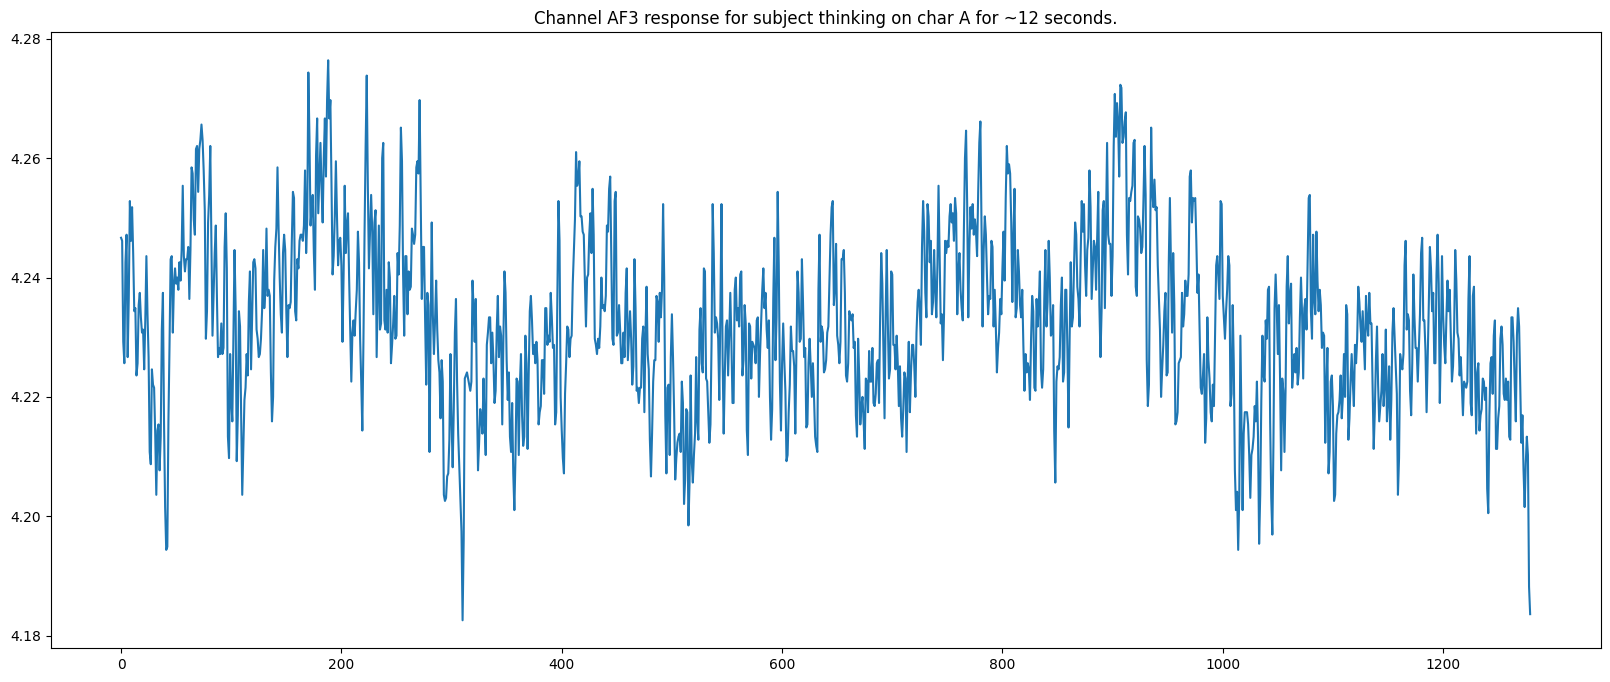

In [13]:
# Extracting a single sensor for tests on building its spectogram
eeg90_af3 = Measurements[47][0]
plt.plot(eeg90_af3, label = 'AF3')
plt.title('Channel AF3 response for subject thinking on char A for ~12 seconds.')

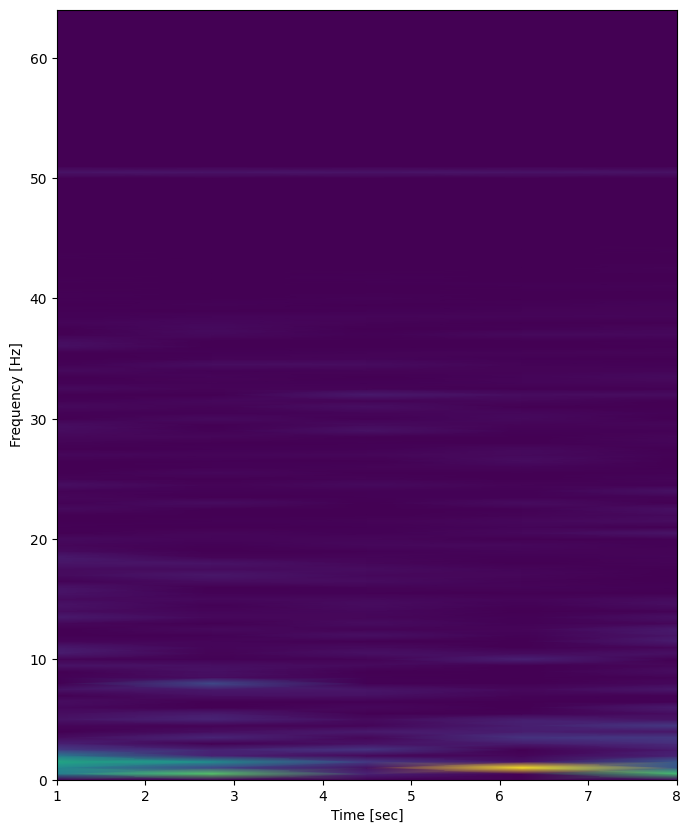

In [14]:
# Transform the array to a 2D Spectogram
from scipy import signal
fs = 128

f, t, Sxx = signal.spectrogram(eeg90_af3, fs)
plt.figure(figsize=(8,10))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(14, 3)

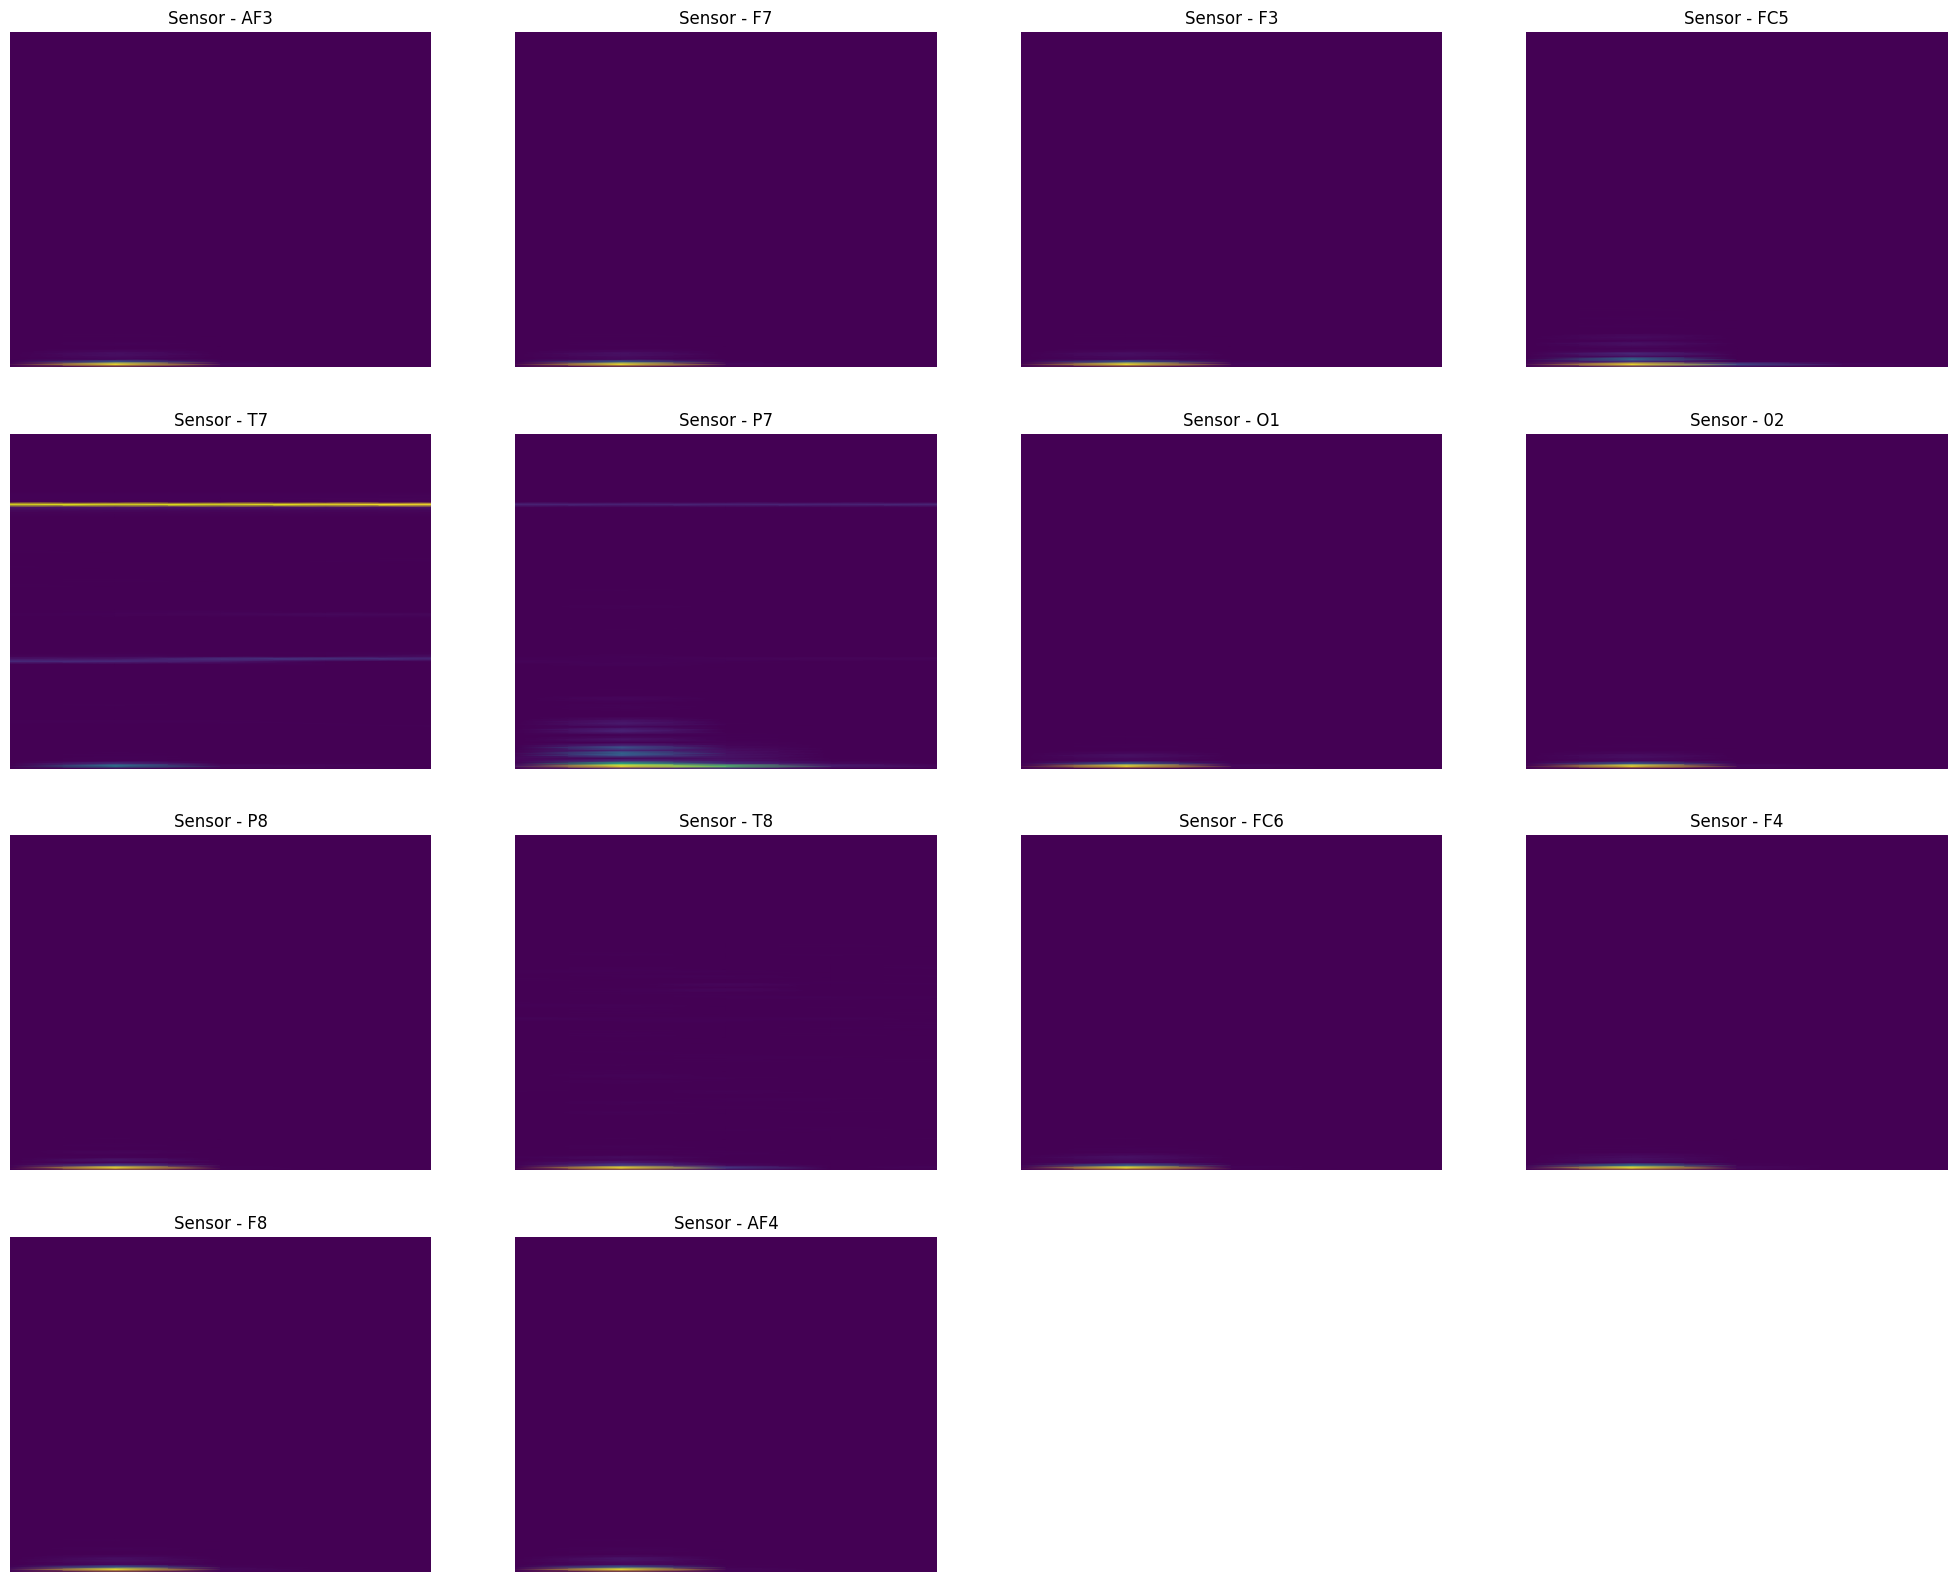

In [15]:
# Extract all sensors from a same EEG:
sensors = {0: 'AF3', 1: 'F7',	2: 'F3', 3:	'FC5', 4: 'T7', 5: 'P7', 6:	'O1',
        7: 'O2', 8: 'P8', 9: 'T8', 10: 'FC6', 11: 'F4', 12: 'F8', 13: 'AF4'}

def eeg_tensor_spectrogram(edf_file, fs): ## On going work
    eeg = []
    for c in range(0,14):
        sensor = Measurements[edf_file][c]
        f, t, Sxx = signal.spectrogram(sensor, fs)
        eeg.append([t, f, Sxx])
    
    f=plt.figure(figsize= (25, 20))
    
    s1 = f.add_subplot(4, 4, 1)
    s1.set_title(f'Sensor - AF3')
    plt.pcolormesh(eeg[0][0], eeg[0][1], eeg[0][2], shading='gouraud')
    plt.axis('off')

    s2 = f.add_subplot(4, 4, 2)
    s2.set_title(f'Sensor - F7')
    plt.pcolormesh(eeg[1][0], eeg[1][1], eeg[1][2], shading='gouraud')
    plt.axis('off')

    s3 = f.add_subplot(4, 4, 3)
    s3.set_title(f'Sensor - F3')
    plt.pcolormesh(eeg[2][0], eeg[2][1], eeg[2][2], shading='gouraud')
    plt.axis('off')

    s4 = f.add_subplot(4, 4, 4)
    s4.set_title(f'Sensor - FC5')
    plt.pcolormesh(eeg[3][0], eeg[3][1], eeg[3][2], shading='gouraud')
    plt.axis('off')

    s5 = f.add_subplot(4, 4, 5)
    s5.set_title(f'Sensor - T7')
    plt.pcolormesh(eeg[4][0], eeg[4][1], eeg[4][2], shading='gouraud')
    plt.axis('off')

    s5 = f.add_subplot(4, 4, 6)
    s5.set_title(f'Sensor - P7')
    plt.pcolormesh(eeg[5][0], eeg[5][1], eeg[5][2], shading='gouraud')
    plt.axis('off')

    s6 = f.add_subplot(4, 4, 7)
    s6.set_title(f'Sensor - O1')
    plt.pcolormesh(eeg[6][0], eeg[6][1], eeg[6][2], shading='gouraud')
    plt.axis('off')

    s7 = f.add_subplot(4, 4, 8)
    s7.set_title(f'Sensor - 02')
    plt.pcolormesh(eeg[7][0], eeg[7][1], eeg[7][2], shading='gouraud')
    plt.axis('off')

    
    s8 = f.add_subplot(4, 4, 9)
    s8.set_title(f'Sensor - P8')
    plt.pcolormesh(eeg[8][0], eeg[8][1], eeg[8][2], shading='gouraud')
    plt.axis('off')

    s9 = f.add_subplot(4, 4, 10)
    s9.set_title(f'Sensor - T8')
    plt.pcolormesh(eeg[9][0], eeg[9][1], eeg[9][2], shading='gouraud')
    plt.axis('off')

    s10 = f.add_subplot(4, 4, 11)
    s10.set_title(f'Sensor - FC6')
    plt.pcolormesh(eeg[10][0], eeg[10][1], eeg[10][2], shading='gouraud')
    plt.axis('off')

    s11 = f.add_subplot(4, 4, 12)
    s11.set_title(f'Sensor - F4')
    plt.pcolormesh(eeg[11][0], eeg[11][1], eeg[11][2], shading='gouraud')
    plt.axis('off')

    s12 = f.add_subplot(4, 4, 13)
    s12.set_title(f'Sensor - F8')
    plt.pcolormesh(eeg[12][0], eeg[12][1], eeg[12][2], shading='gouraud')
    plt.axis('off')

    s13 = f.add_subplot(4, 4, 14)
    s13.set_title(f'Sensor - AF4')
    plt.pcolormesh(eeg[13][0], eeg[13][1], eeg[13][2], shading='gouraud')
    plt.axis('off')
    
    return np.array(eeg, dtype=object)

eeg0 = eeg_tensor_spectrogram(0, 128)
eeg0.shape # -> 14 sensor informations of Sample Frequencies, Segment Times and the Spectrogram of X.

In [16]:
# Lets see if with normalization the data will be less sparse.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [17]:
df = pd.DataFrame(X[0].T, columns=CHANNELS)
df.head().style

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4.224103,4.228205,4.226154,4.226667,4.222051,4.224615,4.213333,4.222564,4.214359,4.232821,4.228718,4.246154,4.231795,4.222051
1,4.229744,4.223590,4.230769,4.230769,4.244103,4.236410,4.222564,4.226154,4.222564,4.234872,4.224615,4.247692,4.231795,4.220513
2,4.233846,4.230769,4.233333,4.230769,4.225641,4.220513,4.230769,4.227179,4.218974,4.234359,4.223590,4.245641,4.230256,4.223077
3,4.231282,4.229231,4.230256,4.229231,4.224103,4.224615,4.230769,4.216923,4.214872,4.232308,4.217436,4.245641,4.223077,4.221026
4,4.226667,4.218462,4.225128,4.228718,4.237949,4.235897,4.224615,4.212308,4.216923,4.232821,4.217436,4.246154,4.222564,4.215897


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,-0.049049,-0.028948,-0.042574,-0.029601,-0.986445,-0.029098,-0.095082,-0.054520,-0.022702,-0.184370,-0.032349,1.068357,-0.010669,-0.074203
1,-0.019496,-0.053196,-0.018137,-0.006124,1.373956,0.371768,-0.050496,-0.037542,-0.014641,0.548528,-0.054523,1.160298,-0.010669,-0.083189
2,0.001996,-0.015477,-0.004561,-0.006124,-0.602194,-0.168530,-0.010864,-0.032692,-0.018167,0.365304,-0.060067,1.037710,-0.019011,-0.068212
3,-0.011437,-0.023559,-0.020852,-0.014928,-0.766873,-0.029098,-0.010864,-0.081199,-0.022198,-0.367594,-0.093328,1.037710,-0.057940,-0.080194
4,-0.035616,-0.080138,-0.048004,-0.017862,0.715239,0.354339,-0.040588,-0.103028,-0.020183,-0.184370,-0.093328,1.068357,-0.060721,-0.110148


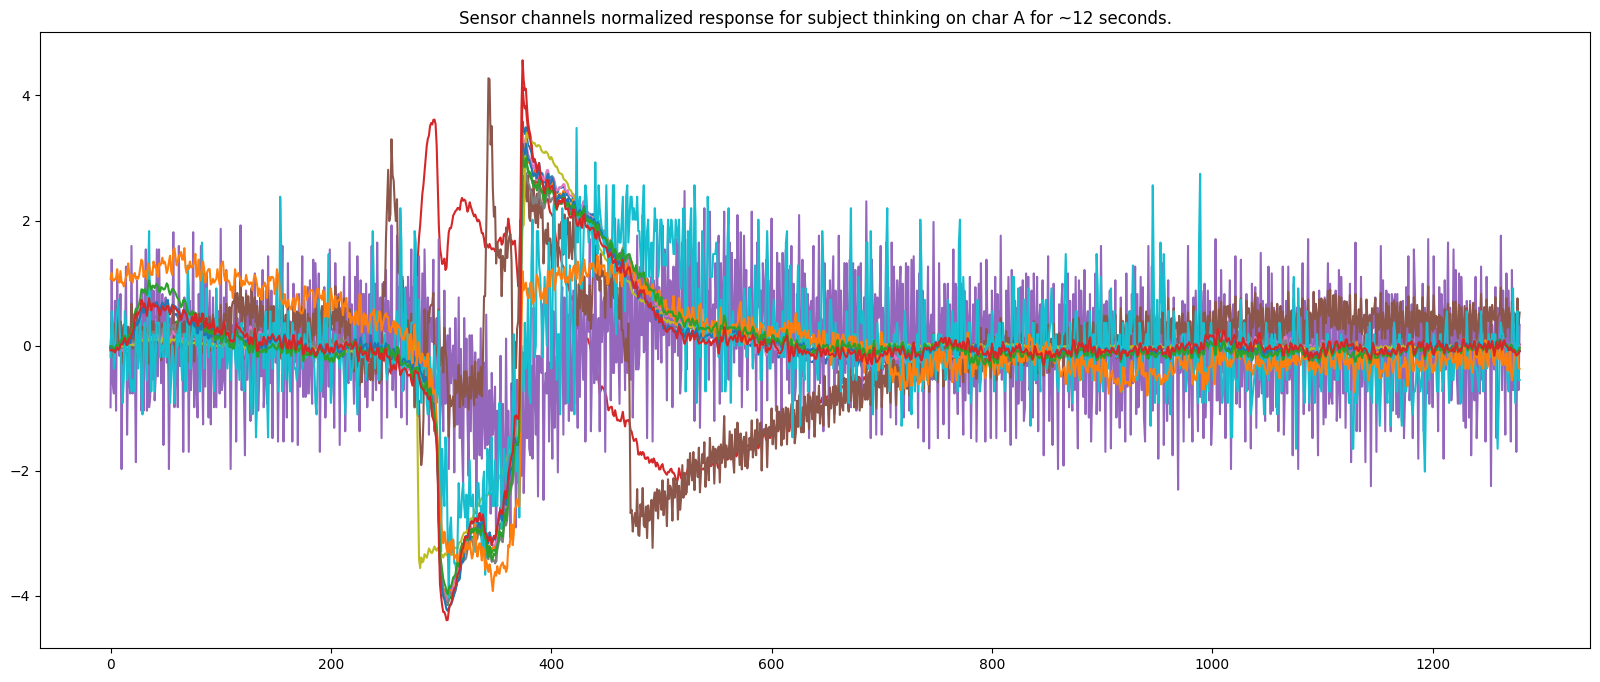

In [18]:
scaler.fit(df[CHANNELS])
z_normalized_df = scaler.transform(df[CHANNELS])
z_normalized_df = pd.DataFrame(z_normalized_df, columns=CHANNELS)

display(z_normalized_df.head().style)
plt.rcParams["figure.figsize"] = (20,8)
for c in CHANNELS:
    plt.plot(z_normalized_df[c], label = str(c))
    plt.title(f'Sensor channels normalized response for subject thinking on char A for ~12 seconds.')

In [19]:
z_normalized_df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03
mean,1.065814e-15,-5.051515e-16,-2.675637e-15,2.220446e-16,-9.085788e-15,1.106337e-14,1.243450e-15,-1.454392e-15,-3.268219e-16,-1.959544e-14,4.329870e-16,1.099121e-14,2.731149e-15,7.993606e-16
std,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00
min,-4.086959e+00,-4.099874e+00,-4.150691e+00,-2.192429e+00,-3.456633e+00,-3.236028e+00,-4.075638e+00,-4.141300e+00,-3.558562e+00,-4.032081e+00,-4.242629e+00,-3.927093e+00,-3.978715e+00,-4.393522e+00
25%,-1.484517e-01,-1.367156e-01,-9.755675e-02,-1.998098e-01,-7.668731e-01,-4.125355e-01,-1.099444e-01,-8.119936e-02,-2.874768e-02,-5.508183e-01,-1.078793e-01,-3.414020e-01,-1.448371e-01,-1.161383e-01
50%,-4.098903e-02,-3.433623e-02,-1.813677e-02,4.083043e-02,5.652269e-02,1.451915e-01,-1.829504e-02,-3.586923e-03,-4.312054e-03,-1.145152e-03,-3.789277e-02,-6.557965e-02,-6.489221e-02,-2.777500e-02
75%,1.121453e-01,1.434805e-01,1.427396e-01,1.376735e-01,8.250255e-01,5.111998e-01,9.874369e-02,1.176825e-01,4.153624e-02,3.653036e-01,1.180178e-01,7.005937e-01,1.116817e-01,1.122584e-01
max,3.583190e+00,3.398066e+00,3.101643e+00,4.563107e+00,2.471817e+00,4.275857e+00,3.340531e+00,2.758931e+00,3.408867e+00,3.480118e+00,3.229994e+00,1.558708e+00,3.081460e+00,4.140278e+00


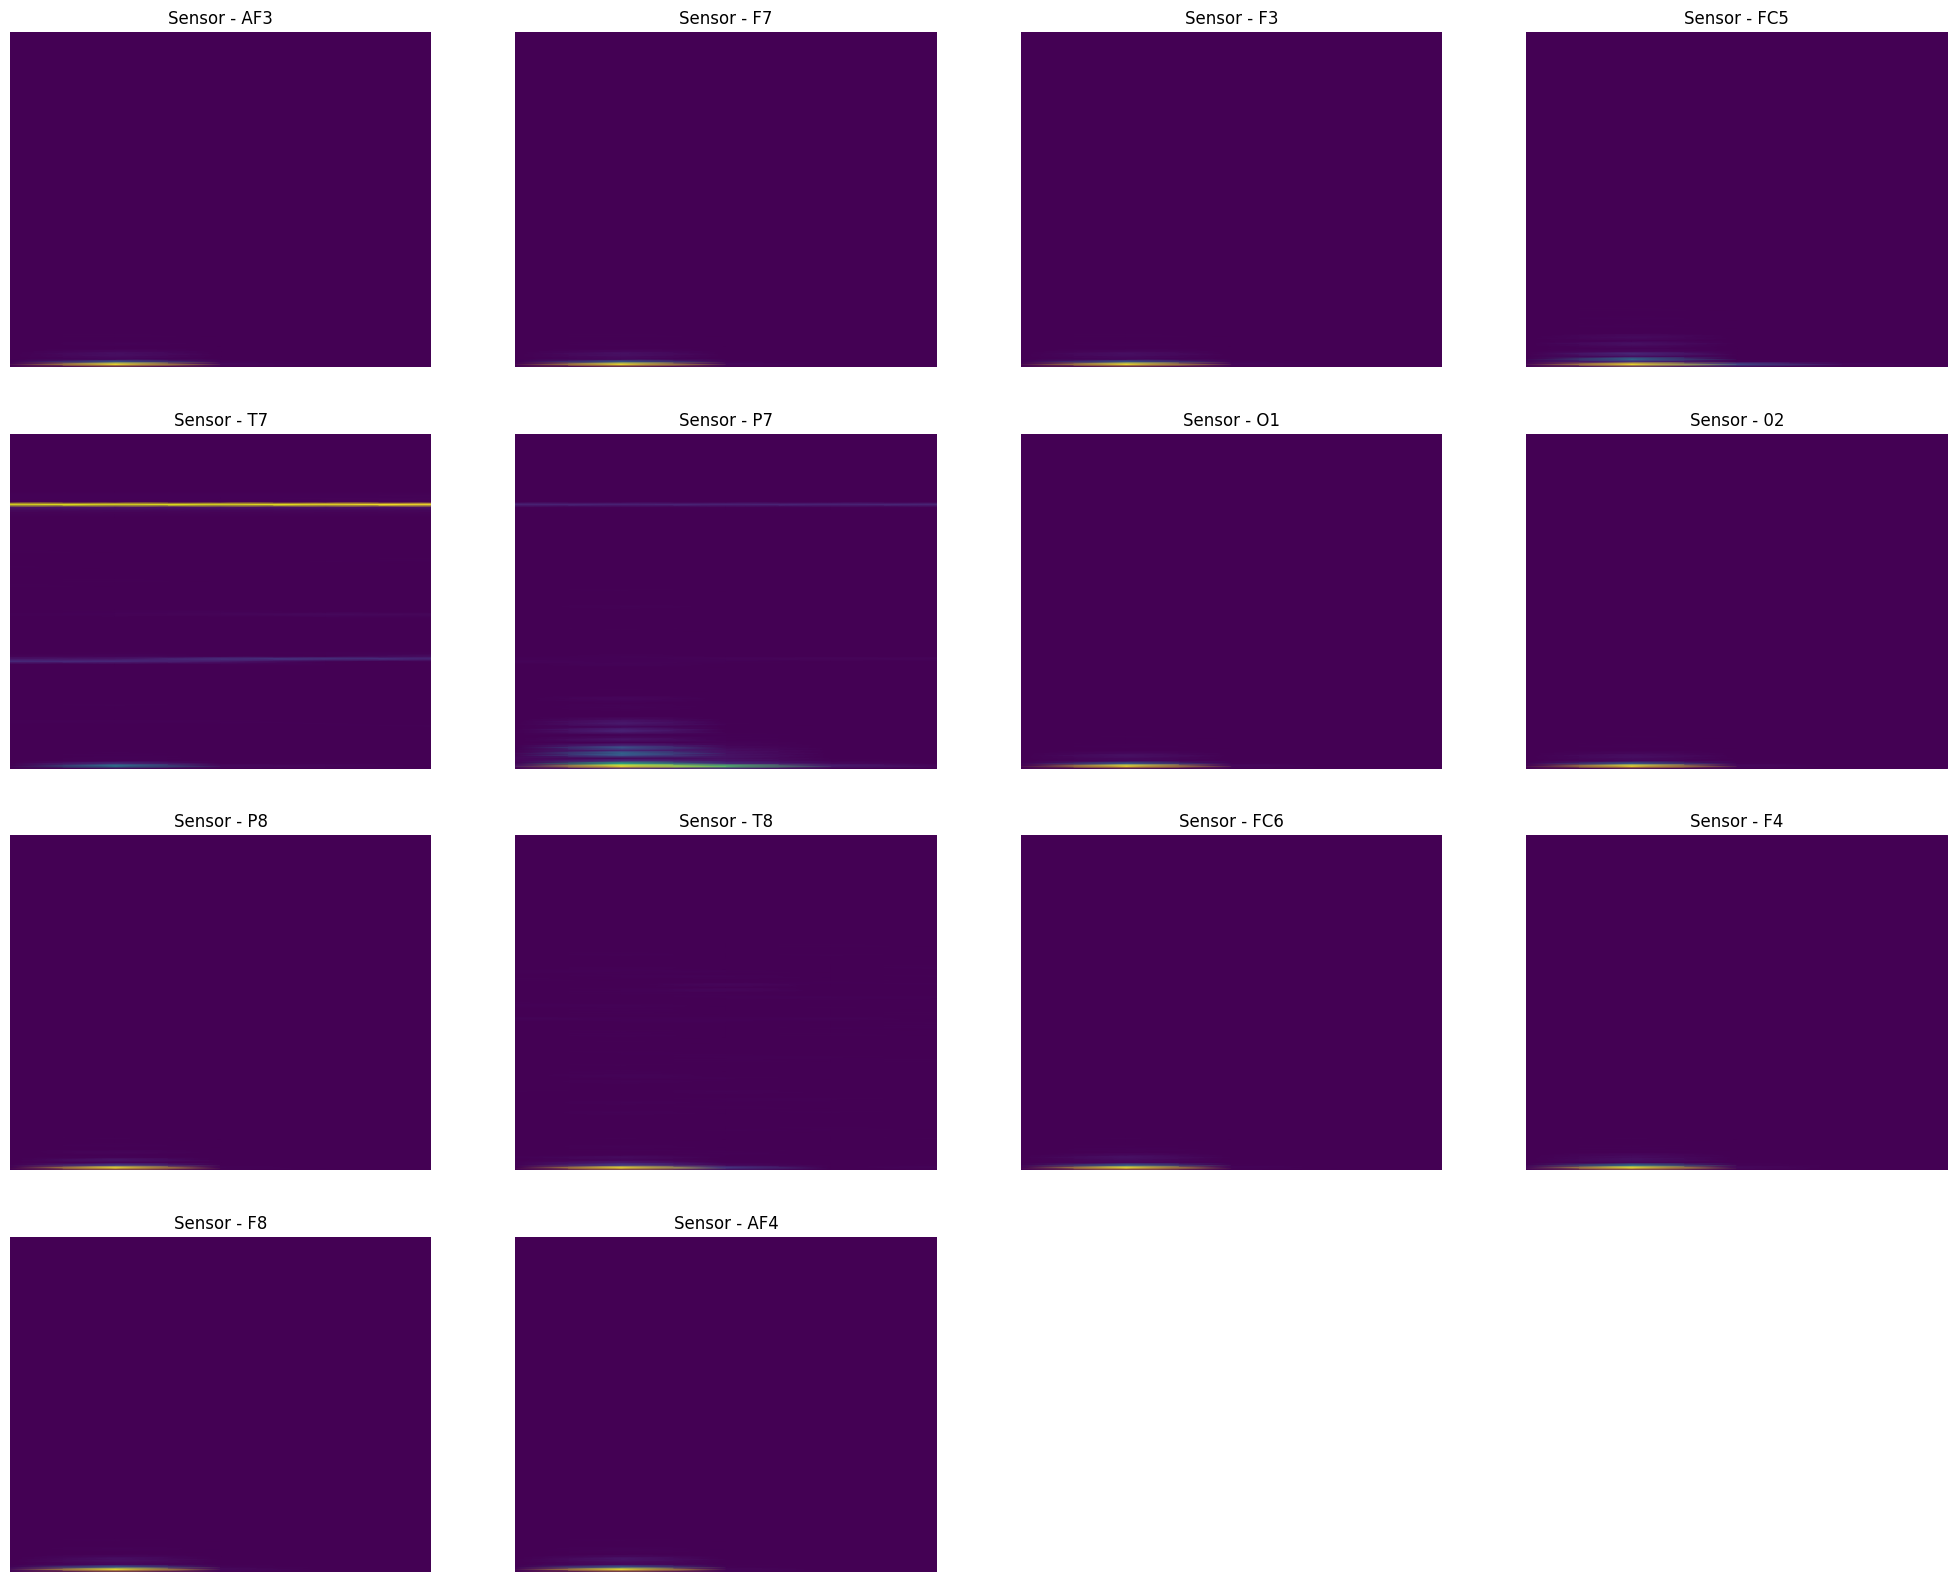

In [20]:
# Lets see if the spectograms for the normalized signals still sparse.

def df_spectrogram(df, fs, Channels = CHANNELS): ## On going work
    eeg = []
    for c in Channels:
        sensor = df[c]
        f, t, Sxx = signal.spectrogram(sensor, fs)
        eeg.append([t, f, Sxx])
    
    f=plt.figure(figsize= (25, 20))
    
    s1 = f.add_subplot(4, 4, 1)
    s1.set_title(f'Sensor - AF3')
    plt.pcolormesh(eeg[0][0], eeg[0][1], eeg[0][2], shading='gouraud')
    plt.axis('off')

    s2 = f.add_subplot(4, 4, 2)
    s2.set_title(f'Sensor - F7')
    plt.pcolormesh(eeg[1][0], eeg[1][1], eeg[1][2], shading='gouraud')
    plt.axis('off')

    s3 = f.add_subplot(4, 4, 3)
    s3.set_title(f'Sensor - F3')
    plt.pcolormesh(eeg[2][0], eeg[2][1], eeg[2][2], shading='gouraud')
    plt.axis('off')

    s4 = f.add_subplot(4, 4, 4)
    s4.set_title(f'Sensor - FC5')
    plt.pcolormesh(eeg[3][0], eeg[3][1], eeg[3][2], shading='gouraud')
    plt.axis('off')

    s5 = f.add_subplot(4, 4, 5)
    s5.set_title(f'Sensor - T7')
    plt.pcolormesh(eeg[4][0], eeg[4][1], eeg[4][2], shading='gouraud')
    plt.axis('off')

    s5 = f.add_subplot(4, 4, 6)
    s5.set_title(f'Sensor - P7')
    plt.pcolormesh(eeg[5][0], eeg[5][1], eeg[5][2], shading='gouraud')
    plt.axis('off')

    s6 = f.add_subplot(4, 4, 7)
    s6.set_title(f'Sensor - O1')
    plt.pcolormesh(eeg[6][0], eeg[6][1], eeg[6][2], shading='gouraud')
    plt.axis('off')

    s7 = f.add_subplot(4, 4, 8)
    s7.set_title(f'Sensor - 02')
    plt.pcolormesh(eeg[7][0], eeg[7][1], eeg[7][2], shading='gouraud')
    plt.axis('off')

    
    s8 = f.add_subplot(4, 4, 9)
    s8.set_title(f'Sensor - P8')
    plt.pcolormesh(eeg[8][0], eeg[8][1], eeg[8][2], shading='gouraud')
    plt.axis('off')

    s9 = f.add_subplot(4, 4, 10)
    s9.set_title(f'Sensor - T8')
    plt.pcolormesh(eeg[9][0], eeg[9][1], eeg[9][2], shading='gouraud')
    plt.axis('off')

    s10 = f.add_subplot(4, 4, 11)
    s10.set_title(f'Sensor - FC6')
    plt.pcolormesh(eeg[10][0], eeg[10][1], eeg[10][2], shading='gouraud')
    plt.axis('off')

    s11 = f.add_subplot(4, 4, 12)
    s11.set_title(f'Sensor - F4')
    plt.pcolormesh(eeg[11][0], eeg[11][1], eeg[11][2], shading='gouraud')
    plt.axis('off')

    s12 = f.add_subplot(4, 4, 13)
    s12.set_title(f'Sensor - F8')
    plt.pcolormesh(eeg[12][0], eeg[12][1], eeg[12][2], shading='gouraud')
    plt.axis('off')

    s13 = f.add_subplot(4, 4, 14)
    s13.set_title(f'Sensor - AF4')
    plt.pcolormesh(eeg[13][0], eeg[13][1], eeg[13][2], shading='gouraud')
    plt.axis('off')
    
    return np.array(eeg, dtype=object)

norm_eeg = df_spectrogram(z_normalized_df, 128)

In [21]:
# We will need to step away from the spectogram aproach, but the z-normalization was a good move for the next model we will use, the Transformer.
# Lets Build a Z-Normalized dataset

m,n,r = X.shape
COLUMNS = ['EEG','AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] 
out_arr = np.column_stack((np.repeat(np.arange(m),n),X.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)
df0 =out_df[(out_df[0]==0)]
df0.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.224103,4.228205,4.226154,4.226667,4.222051,4.224615,4.213333,4.222564,4.214359,4.232821,4.228718,4.246154,4.231795,4.222051
2,4.229744,4.223590,4.230769,4.230769,4.244103,4.236410,4.222564,4.226154,4.222564,4.234872,4.224615,4.247692,4.231795,4.220513
3,4.233846,4.230769,4.233333,4.230769,4.225641,4.220513,4.230769,4.227179,4.218974,4.234359,4.223590,4.245641,4.230256,4.223077
4,4.231282,4.229231,4.230256,4.229231,4.224103,4.224615,4.230769,4.216923,4.214872,4.232308,4.217436,4.245641,4.223077,4.221026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,4.217949,4.215385,4.216923,4.229231,4.233846,4.240000,4.228205,4.229231,4.215897,4.230769,4.215385,4.226667,4.217436,4.214359
1277,4.212821,4.219487,4.210256,4.227179,4.215385,4.227179,4.226154,4.220000,4.191282,4.233333,4.214359,4.225641,4.215385,4.207692
1278,4.214872,4.214359,4.214359,4.236923,4.236410,4.247692,4.228718,4.226154,4.213846,4.234872,4.217949,4.226154,4.215897,4.209744
1279,4.208718,4.213333,4.213333,4.230256,4.224615,4.235385,4.227692,4.224103,4.209744,4.231795,4.214359,4.222564,4.219487,4.213333


In [22]:
# Z-Normalized and added a random noise of 0.01 normal random distributed numbers to prevent overfit
def zScoreNorm(df, channels=CHANNELS):
    np.random.seed(0)
    scaler = StandardScaler()
    scaler.fit(df[CHANNELS])
    z_normalized_df = scaler.transform(df[CHANNELS]) + (0.01*np.random.randn())
    return pd.DataFrame(z_normalized_df, columns=CHANNELS)

In [23]:
# Create the normalized dataframe
COLUMNS = ['EEG', 'MEASUREMENT', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] 

eegs_df = pd.DataFrame(X[0].T, columns=CHANNELS)
eegs_df = zScoreNorm(eegs_df)
eegs_df['EEG'] = 0
eegs_df['MEASUREMENT'] = eegs_df.index
for eeg in tqdm(range(1,230)):
    exam = pd.DataFrame(X[eeg].T, columns=CHANNELS)
    exam = zScoreNorm(exam)
    exam['EEG'] = eeg
    exam['MEASUREMENT'] = exam.index
    eegs_df = pd.concat([eegs_df, exam], ignore_index=True)
eegs_df[COLUMNS]

100%|██████████| 229/229 [00:01<00:00, 124.39it/s]


,EEG,MEASUREMENT,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0,0,-0.031408,-0.011307,-0.024933,-0.011960,-0.968805,-0.011458,-0.077442,-0.036880,-0.005061,-0.166729,-0.014709,1.085997,0.006972,-0.056563
1,0,1,-0.001856,-0.035555,-0.000496,0.011517,1.391597,0.389409,-0.032856,-0.019902,0.003000,0.566169,-0.036883,1.177938,0.006972,-0.065549
2,0,2,0.019637,0.002164,0.013080,0.011517,-0.584553,-0.150889,0.006777,-0.015051,-0.000527,0.382944,-0.042426,1.055350,-0.001370,-0.050572
3,0,3,0.006204,-0.005919,-0.003211,0.002713,-0.749233,-0.011458,0.006777,-0.063559,-0.004557,-0.349953,-0.075687,1.055350,-0.040300,-0.062553
4,0,4,-0.017975,-0.062497,-0.030364,-0.000222,0.732880,0.371980,-0.022948,-0.085387,-0.002542,-0.166729,-0.075687,1.085997,-0.043081,-0.092507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294395,229,1275,1.049497,-0.111691,0.071205,-0.062277,0.823257,0.750754,0.487898,0.316951,-0.210399,0.431939,0.719014,0.488716,0.202793,0.305665
294396,229,1276,1.670027,0.306721,0.984834,0.450155,0.021919,1.823603,1.407110,1.157324,0.867918,1.869072,1.545965,0.722497,0.527258,0.869297
294397,229,1277,0.977897,0.160277,0.468435,0.001777,-0.645864,1.609034,-1.146255,0.877199,-0.308428,0.431939,0.787927,0.681242,0.229832,0.108394
294398,229,1278,1.407495,0.055674,0.587604,0.129885,1.491039,1.680557,1.151773,0.877199,0.240534,-0.645911,0.477820,0.873767,-0.662448,0.446573


In [24]:
# Transform into array
multiindex_df = eegs_df.set_index(['EEG', 'MEASUREMENT'])
X_normalized = multiindex_df.values.reshape(230, 14, 1280)
X_SA_normalized = multiindex_df.values.reshape(230, 17920)
X_normalized.shape
X_SA_normalized.shape

(230, 17920)

In [25]:
# Save new dataset
np.savez('char_normalized_dataset', x=X_normalized, y=Y)
np.savez('char_normalized_flatten_dataset', x=X_SA_normalized, y=Y)

In [26]:
dataset = np.load('char_normalized_dataset.npz')
Measurements = dataset['x']
Labels = dataset['y']
print(Measurements.shape)
print(Labels.shape)

(230, 14, 1280)
(230,)
